## 주제 : KOSPI와 세계 각국의 지수들을 사용해서 상관관계 및 군집분석을 진행하고 CAPM을 사용해서 포트폴리오를 작성

## 이번 분석에 사용할 Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr
import seaborn as sns
from matplotlib import rc
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import cvxopt as opt
from cvxopt import solvers
import warnings
warnings.filterwarnings(action='ignore')

## 1. 세계 각국의 지수들 관련 데이터 불러오기

### 1. KOSPI

#### - KOSPI 데이터 전처리

change(수익률)에 * 100을 해서 %수치로 보이기 편하게 수정하였고,\
Open(시가), High(고가), Close(종가), Volume(거래량)을 제거하였습니다.

In [2]:
df = pd.read_csv('kospi_data.csv')
df['Change'] = df['Change'] * 100
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df = df.set_index('Date')
df.rename(columns = {'Change':'KOSPI'},inplace=True)
df

,KOSPI
Date,
1981-05-01,0.98
1981-05-02,-0.08
1981-05-04,-2.35
1981-05-06,0.08
1981-05-07,-1.16
...,...
2022-08-25,1.22
2022-08-26,0.15
2022-08-29,-2.18


### 2. Nasdaq

#### Nasdaq 데이터를 불러오기

yfinance Library를 사용해서 NASDAQ 데이터를 불러왔고, \
전처리과정은 kospi 데이터와 동일하게 진행하였습니다.

In [4]:
nasdaq = pdr.get_data_yahoo('^IXIC', start = '1981-05-01', end = '2022-08-31')
nasdaq.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis = 1, inplace = True)
nasdaq['Change'] = round(nasdaq['Adj Close'].pct_change() *100, 2)
nasdaq.drop('Adj Close', axis = 1, inplace = True)
nasdaq.drop('1981-04-30', inplace = True)

In [5]:
nasdaq.rename(columns = {'Change':'NASDAQ'},inplace=True)
nasdaq

,NASDAQ
Date,
1981-05-01,-0.03
1981-05-04,-1.55
1981-05-05,-0.83
1981-05-06,0.20
1981-05-07,0.79
...,...
2022-08-25,1.67
2022-08-26,-3.94
2022-08-29,-1.02


###  3. S&P 

#### - S&P 데이터 불러오기 

In [6]:
sap = pdr.get_data_yahoo('^GSPC', start = '1981-05-01', end = '2022-08-31')
sap['Change'] = round(sap['Adj Close'].pct_change() * 100, 2)
sap.drop('1981-04-30', inplace = True)
sap.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)
sap.rename(columns = {'Change':'S&P'},inplace=True)
sap

,S&P
Date,
1981-05-01,-0.07
1981-05-04,-1.54
1981-05-05,-0.27
1981-05-06,0.35
1981-05-07,0.68
...,...
2022-08-25,1.41
2022-08-26,-3.37
2022-08-29,-0.67


### 4. 미국 10년 국채

#### - 미국 10년 국채 데이터 불러오기

In [7]:
usa_treasury = pdr.get_data_yahoo('^TNX', start = '1981-05-01', end = '2022-08-31')
usa_treasury['Change'] = round(usa_treasury['Adj Close'].pct_change() * 100, 2)
usa_treasury.drop('1981-04-30', inplace = True)
usa_treasury.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)

In [8]:
usa_treasury.rename(columns = {'Change':'USA_TREASURY'},inplace=True)
usa_treasury

,USA_TREASURY
Date,
1981-05-01,-0.43
1981-05-04,2.99
1981-05-05,1.52
1981-05-06,-0.88
1981-05-07,-1.58
...,...
2022-08-25,-2.58
2022-08-26,0.30
2022-08-29,2.47


### 5. Nikkei

#### - Nikkei 데이터 불러오기

In [9]:
japan = pdr.get_data_yahoo('^N225', start = '1981-05-01', end = '2022-08-31')
japan['Change'] = round(japan['Adj Close'].pct_change() * 100, 2)
japan.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)

In [10]:
japan.rename(columns = {'Change':'Nikkei'},inplace=True)
japan

,Nikkei
Date,
1981-05-01,NaN
1981-05-06,-1.46
1981-05-07,-0.33
1981-05-08,0.74
1981-05-11,0.75
...,...
2022-08-25,0.58
2022-08-26,0.57
2022-08-29,-2.66


### 6. Dollar 환율 

예전에는 FinanceDataReader Library로 달러환율(USA/KRW)를 불러올수 있었는데 지금은 불러오기 힘들어서\
 기존에 가지고있던 데이터를 가져왔습니다.

In [11]:
df1 = pd.read_csv('수익률1.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)
df1.drop(['Kospi', 'NASDAQ', 'S&P', 'USA_TREASURY', 'Nikkei'], axis = 1, inplace = True)
df1

,Dollar
Date,
1981-05-01,0.10
1981-05-02,0.01
1981-05-04,0.00
1981-05-05,0.00
1981-05-06,0.07
...,...
2022-08-25,-0.47
2022-08-26,0.56
2022-08-29,0.28


## 2. 세계 각국의 지수들 데이터 병합
각 지수들 및 환율 국채를 합쳐줍니다.\
결측치는 평균으로 대체하였습니다.

In [12]:
result_data = pd.concat([df, nasdaq, sap, df1, usa_treasury, japan], axis = 1)
result_data.fillna(result_data.mean(), inplace = True)
result_data = round(result_data, 2)
result_data

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei
Date,,,,,,
1981-05-01,0.98,-0.03,-0.07,0.10,-0.43,0.02
1981-05-02,-0.08,0.05,0.04,0.01,0.00,0.02
1981-05-04,-2.35,-1.55,-1.54,0.00,2.99,0.02
1981-05-05,0.04,-0.83,-0.27,0.00,1.52,0.02
1981-05-06,0.08,0.20,0.35,0.07,-0.88,-1.46
...,...,...,...,...,...,...
2022-08-25,1.22,1.67,1.41,-0.47,-2.58,0.58
2022-08-26,0.15,-3.94,-3.37,0.56,0.30,0.57
2022-08-29,-2.18,-1.02,-0.67,0.28,2.47,-2.66


## 3. 군집분석

### 1. K_means 를 사용하여 군집을 분류하였습니다.
       kospi 를 target으로 설정하였습니다

In [13]:
x= result_data[["NASDAQ","S&P","Dollar","USA_TREASURY","Nikkei"]]
y= result_data["KOSPI"]

### 2. N = 4 일때 최적의 분류를 확인

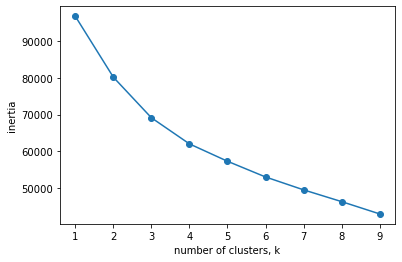

In [14]:
ks = range(1,10)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(x) # tsne한 놈
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show() 

### 3. N= 4로 군집분석 진행 

In [15]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters,random_state=35)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
# kmeans.fit(tsne_features) # 축소된놈 Fitting
kmeans.fit(x) # 축소 안한놈 Fitting
# kmeans.fit(features_kpca)

# y_kmeans = kmeans.predict(tsne_features)
y_kmeans = kmeans.predict(x)
# y_kmeans = kmeans.predict(features_kpca)

y_kmeans[1:10] # 군집화 된 결과

array([0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

### 4. TSNE를 통한 차원축소 진행

In [16]:
import time
from sklearn.manifold import TSNE

n_sne = x.shape[0]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=32, n_iter=1000,random_state=0,angle=0.5)
tsne_results = tsne.fit_transform(x)

print( 't-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start ))

[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 11628 samples in 0.015s...
[t-SNE] Computed neighbors for 11628 samples in 0.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11628
[t-SNE] Computed conditional probabilities for sample 2000 / 11628
[t-SNE] Computed conditional probabilities for sample 3000 / 11628
[t-SNE] Computed conditional probabilities for sample 4000 / 11628
[t-SNE] Computed conditional probabilities for sample 5000 / 11628
[t-SNE] Computed conditional probabilities for sample 6000 / 11628
[t-SNE] Computed conditional probabilities for sample 7000 / 11628
[t-SNE] Computed conditional probabilities for sample 8000 / 11628
[t-SNE] Computed conditional probabilities for sample 9000 / 11628
[t-SNE] Computed conditional probabilities for sample 10000 / 11628
[t-SNE] Computed conditional probabilities for sample 11000 / 11628
[t-SNE] Computed conditional probabilities for sample 11628 / 11628
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence

### 5. 군집분석 결과 시각화

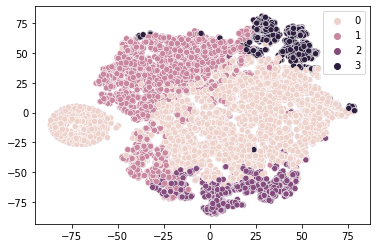

In [17]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_kmeans, s=20, cmap='bwr')
sns.scatterplot(tsne_results[:,0], tsne_results[:,1],data=result_data,hue=y_kmeans,cmap='bwr')
plt.show()

## 군집이 괜찮게 분류된거 같습니다. 

In [18]:
df1 = result_data.copy()

In [19]:
df1['cluster'] = y_kmeans
df1

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-05-01,0.98,-0.03,-0.07,0.10,-0.43,0.02,0
1981-05-02,-0.08,0.05,0.04,0.01,0.00,0.02,0
1981-05-04,-2.35,-1.55,-1.54,0.00,2.99,0.02,0
1981-05-05,0.04,-0.83,-0.27,0.00,1.52,0.02,0
1981-05-06,0.08,0.20,0.35,0.07,-0.88,-1.46,0
...,...,...,...,...,...,...,...
2022-08-25,1.22,1.67,1.41,-0.47,-2.58,0.58,1
2022-08-26,0.15,-3.94,-3.37,0.56,0.30,0.57,2
2022-08-29,-2.18,-1.02,-0.67,0.28,2.47,-2.66,0


### 6. 군집분석 결과에 따른 군집들을 새로운 데이터 프레임으로 생성 

In [20]:
## 군집 0 ~ 3 까지 분류된거를 변수명에 추가

cluster_3 = df1[df1['cluster']==3]
cluster_2 = df1[df1['cluster']==2]
cluster_1 = df1[df1['cluster']==1]
cluster_0 = df1[df1['cluster']==0]

In [21]:
cluster_0

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-05-01,0.98,-0.03,-0.07,0.10,-0.43,0.02,0
1981-05-02,-0.08,0.05,0.04,0.01,0.00,0.02,0
1981-05-04,-2.35,-1.55,-1.54,0.00,2.99,0.02,0
1981-05-05,0.04,-0.83,-0.27,0.00,1.52,0.02,0
1981-05-06,0.08,0.20,0.35,0.07,-0.88,-1.46,0
...,...,...,...,...,...,...,...
2022-08-23,-1.10,-0.00,-0.22,-0.32,0.56,-1.19,0
2022-08-24,0.50,0.41,0.29,0.11,1.70,-0.49,0
2022-08-29,-2.18,-1.02,-0.67,0.28,2.47,-2.66,0


In [22]:
cluster_1

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-05-07,-1.16,0.79,0.68,0.00,-1.58,-0.33,1
1981-05-08,-0.50,0.55,-0.01,0.04,-0.70,0.74,1
1981-05-14,1.33,0.65,0.56,0.19,-1.73,1.04,1
1981-05-15,-0.08,0.62,0.68,0.10,-1.19,0.26,1
1981-05-18,-0.33,0.20,0.28,0.01,-1.92,-0.47,1
...,...,...,...,...,...,...,...
2022-08-04,0.47,0.41,-0.08,-0.41,-2.62,0.69,1
2022-08-10,-0.90,2.89,2.13,-0.67,-0.39,-0.65,1
2022-08-12,0.16,2.09,1.73,-0.29,-1.35,2.62,1


In [23]:
cluster_2

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-07-06,1.96,-1.74,-0.99,0.00,-1.00,0.03,2
1981-09-17,-1.54,-1.12,-1.45,0.00,-1.06,0.44,2
1981-11-06,-1.81,-0.02,-0.70,0.00,-1.76,-0.13,2
1981-11-09,-1.69,-0.03,0.51,0.00,-3.95,-0.27,2
1981-11-16,1.68,-1.50,-1.18,0.00,-0.83,1.39,2
...,...,...,...,...,...,...,...
2022-07-12,-0.96,-0.95,-0.92,-0.43,-1.10,-1.77,2
2022-07-22,-0.66,-1.87,-0.93,0.29,-4.36,0.40,2
2022-07-26,0.39,-1.87,-1.15,-0.08,-1.17,-0.16,2


In [24]:
cluster_3

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-07-20,-2.21,-1.64,-1.56,0.00,3.55,-0.47,3
1981-11-23,2.47,-0.30,-0.09,0.00,2.28,0.02,3
1981-12-07,-0.38,-0.58,-0.85,0.00,2.66,0.95,3
1982-02-01,-0.42,-0.83,-2.18,0.00,3.11,-0.11,3
1982-07-26,0.00,-0.38,-0.73,0.00,2.58,-0.23,3
...,...,...,...,...,...,...,...
2022-07-19,-0.18,3.11,2.76,-1.00,1.99,0.65,3
2022-08-02,-0.52,-0.16,-0.67,0.34,5.18,-1.42,3
2022-08-05,0.72,-0.50,-0.16,-0.01,6.13,0.87,3


#### 7. 군집별 수익률 확인

군집 0 ~ 3 까지의 수익률을 한번 확인

In [25]:
cluster_total= df1.groupby('cluster').mean()
cluster_total['return'] = cluster_total.T.mean()
cluster_total['std'] = cluster_total.T.std()
cluster_total = cluster_total.T
cluster_total

cluster,0,1,2,3
KOSPI,-0.082534,0.337719,-0.420553,0.317360
NASDAQ,-0.169192,0.839928,-1.776647,0.919845
S&P,-0.155392,0.693340,-1.397946,0.770630
Dollar,0.031772,-0.085584,0.211190,-0.054185
USA_TREASURY,0.205059,-0.421760,-2.390193,3.710095
Nikkei,-0.384492,0.825758,-0.501676,0.376290
return,-0.092463,0.364900,-1.045971,1.006673
std,0.182200,0.477567,0.888122,1.249647


군집0 : Dollar, USA_TREASURY가 메인으로 이뤄진 군집  
군집1 : 위험자산으로 이뤄진 군집  
군집2 : Dolllar로 이뤄진 군집  
군집3 : 위험자산 + USA_TREASURY로 이뤄진 군집  

금융시장에서의 수익률 : 위험자산 > 국채 > 달러  
금융시장에서의 표준편차(위험) : 달러 > 국채 > 위험자산

#### 8. 군집별 수익률 대비 risk 시각화

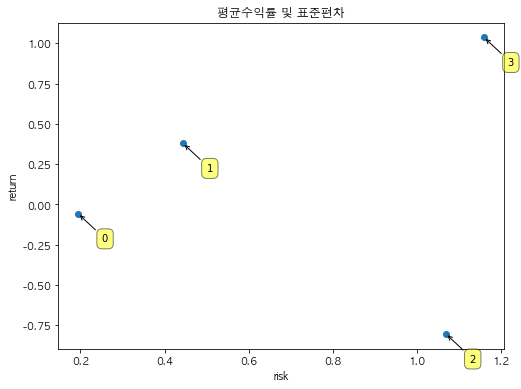

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(cluster_total.std(), cluster_total.mean())
plt.xlabel('risk')
plt.ylabel('return')
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('평균수익률 및 표준편차')
for label, x, y in zip(cluster_total.columns, cluster_total.std(), cluster_total.mean()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))   

각 금융자산의 특징과 잘 맞게 군집이 잘 작성되었습니다.

## 4. 상관관계 분석

Kospi와 나머지 변수들의 상관관계를 확인

#### 1. 히트맵

In [29]:
df2 = df1.corr()

<AxesSubplot:>

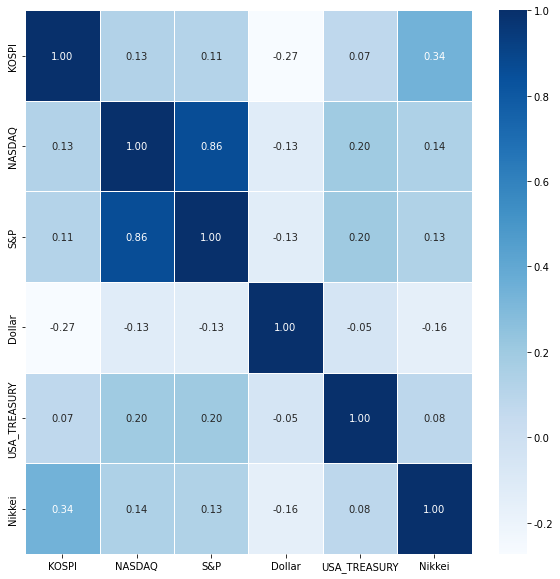

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(result_data.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

#### 2. 상관관계 계수 확인하기

확실히 Nasdaq과 S&P가 서로 미국시장이라서 상관관계가 높은것을 확인할 수 있습니다. \
kospi와의 상관관계는 1.Nikkei > 2. Nasdaq > 3. S&P > 4.usa_treasury > 5.Dollar 순의 상관관계를 보이고 있습니다.

In [31]:
idx, vals = [], []
for ix, i in enumerate(result_data.columns.values):
    for j in result_data.columns.values[ix + 1:]:
        idx.append((i, j))
        vals.append(result_data.corr()[i][j])

ser = pd.Series(data=vals, index=idx)
ser_ord = ser.sort_values(ascending=False)
ser_ord

(NASDAQ, S&P)             0.857595
(KOSPI, Nikkei)           0.340290
(S&P, USA_TREASURY)       0.202040
(NASDAQ, USA_TREASURY)    0.195795
(NASDAQ, Nikkei)          0.142628
(S&P, Nikkei)             0.131779
(KOSPI, NASDAQ)           0.126443
(KOSPI, S&P)              0.114840
(USA_TREASURY, Nikkei)    0.081461
(KOSPI, USA_TREASURY)     0.073295
(Dollar, USA_TREASURY)   -0.052974
(NASDAQ, Dollar)         -0.127816
(S&P, Dollar)            -0.130904
(Dollar, Nikkei)         -0.155514
(KOSPI, Dollar)          -0.273254
dtype: float64

### 3. 산점도 그래프

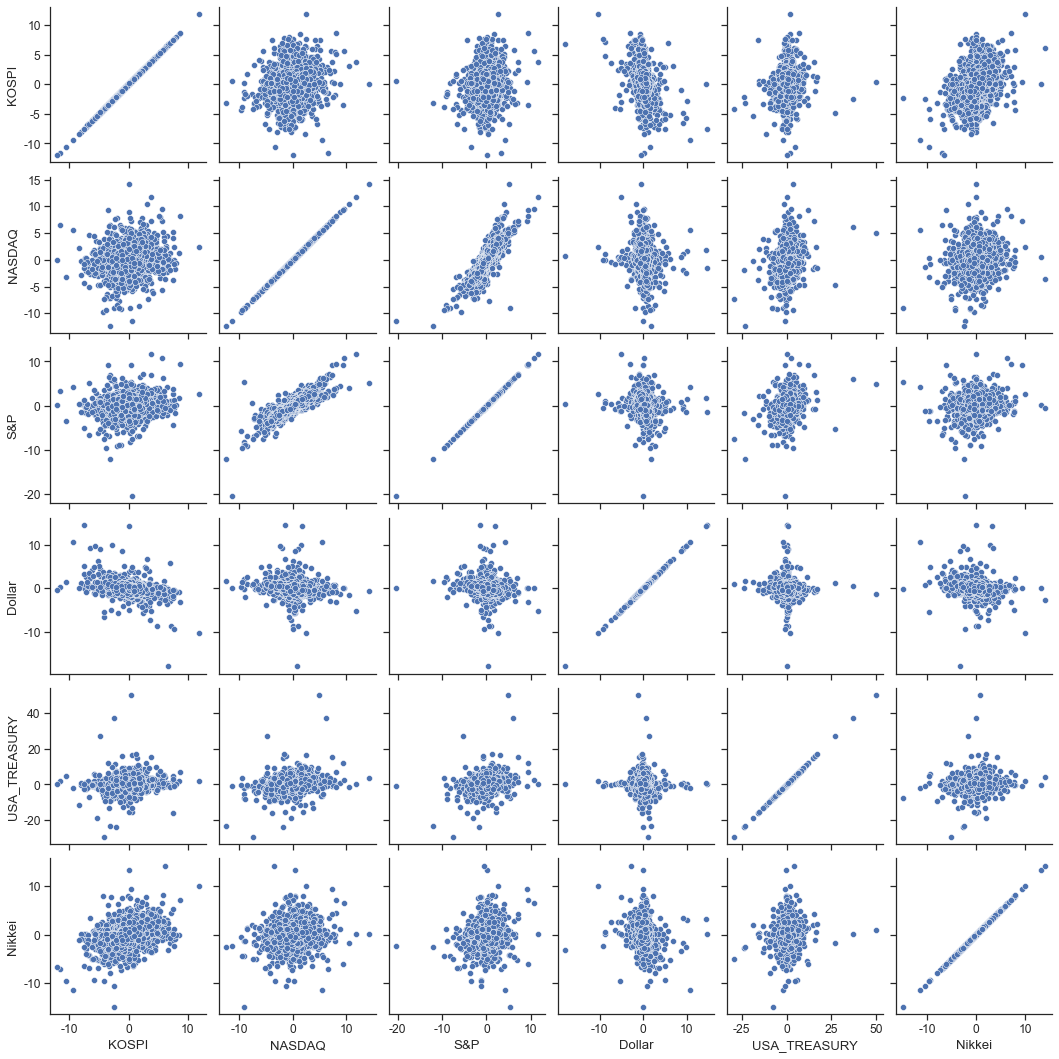

In [32]:
sns.set(font_scale=1.1) ## 폰트사이즈 조절
sns.set_style('ticks') ## 축 눈금 표시
data = result_data[["KOSPI", "NASDAQ","S&P","Dollar","USA_TREASURY","Nikkei"]]
sns.pairplot(data,diag_kind=None)
plt.show()

## 5. 세계 각국 지수의 수익률 대비 risk 시각화

#### -  1. 평균수익률 및 표준편차

findfont: Font family ['Apple Gothic'] not found. Falling back to DejaVu Sans.


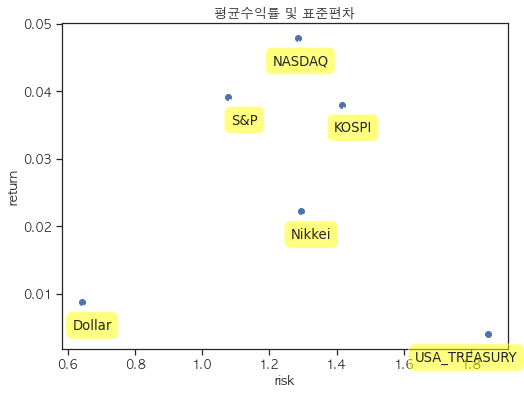

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(result_data.std(), result_data.mean())
plt.xlabel('risk')
plt.ylabel('return')
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('평균수익률 및 표준편차')
for label, x, y in zip(result_data.columns, result_data.std(), result_data.mean()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))   

#### -  2. 누적수익률 및 표준편차 

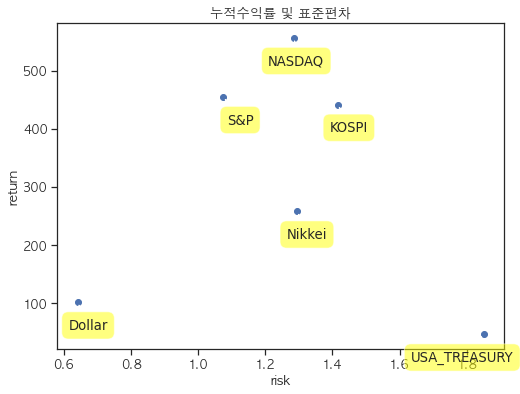

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(result_data.std(), result_data.sum())
plt.xlabel('risk')
plt.ylabel('return')
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('누적수익률 및 표준편차')
for label, x, y in zip(result_data.columns, result_data.std(), result_data.sum()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))   

#### -  3. 세계 각국 지수들의 수익률 대비 risk에 대한 결과 분석
금융자산에서 표준편차(std) = 위험(risk)입니다.  
안전자산인 Dollar는 수익률이 적지만 위험이 그만큼 낮습니다. 미국채권의 경우 수익률은 낮은데 위험은 높습니다  
나머지 위험자산(각 나라 지수들)은 수익률이 높지만 그만큼 리스크가 있다는것을 확인할 수 있습니다.  
Kospi는 위험(risk) 대비 다른자산보다 수익률이 좋지 않습니다. 확실히 한국시장이 다른 시장보다 저평가 받는걸 확인할 수 있습니다.

## 6. CAPM 기반의 포트폴리오 작성

#### -  CAPM(자본자산 가격결정 모형) 

자본시장이 균형상태(시장에서 수요와 공급이 일치되도록 가격이 형성된 상태)에 있을 때, (자본)자산의 균형가격이 위험을 반영하여 어떻게 결정되는지를 보여주는 모형

CAPM : E(R) = rf + B[E(rm) -rf)]  

E(R) = 기대수익률  
rf = 무위험수익률  
B = 베타  
E(rm) - rf = 위험프리미엄

#### -  Efficient frontier(효율적 프톤티어)

현대 포트폴리오 이론에서 효율적인 경계는 위험-수익 스펙트럼의 "효율적인"부분을 차지하는 투자 포트폴리오입니다. 공식적으로는 기대 수익이 더 높지만 수익의 표준 편차가 같은 다른 포트폴리오가 존재하지 않는다는 조건을 만족하는 포트폴리오 세트입니다.  

#### -  1. cluster_0 의 포트폴리오 구성

In [37]:
cluster_0

,KOSPI,NASDAQ,S&P,Dollar,USA_TREASURY,Nikkei,cluster
Date,,,,,,,
1981-05-01,0.98,-0.03,-0.07,0.10,-0.43,0.02,0
1981-05-02,-0.08,0.05,0.04,0.01,0.00,0.02,0
1981-05-04,-2.35,-1.55,-1.54,0.00,2.99,0.02,0
1981-05-05,0.04,-0.83,-0.27,0.00,1.52,0.02,0
1981-05-06,0.08,0.20,0.35,0.07,-0.88,-1.46,0
...,...,...,...,...,...,...,...
2022-08-23,-1.10,-0.00,-0.22,-0.32,0.56,-1.19,0
2022-08-24,0.50,0.41,0.29,0.11,1.70,-0.49,0
2022-08-29,-2.18,-1.02,-0.67,0.28,2.47,-2.66,0


#### -  3. 기대수익률

E(R) = W1 * R1 + W2 * R2 + ..... Wn * Rn  
W = 가중치(확률), R = 수익률

In [38]:
## 기대수익률을 구하기 위한 가중치를 랜덤으로 불러옵니다. 

def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)
rand_weights(6) ## kospi를 포함 6개의 자산이므로 n = 6.

array([0.05449181, 0.39597587, 0.03803108, 0.00816896, 0.36176862,
       0.14156366])

In [39]:
cluster_0.drop('cluster', axis = 1, inplace = True)

In [40]:
returns_matrix = cluster_0.values.T
returns_matrix

array([[ 0.98, -0.08, -2.35, ..., -2.18,  0.99,  0.86],
       [-0.03,  0.05, -1.55, ..., -1.02, -1.12, -0.56],
       [-0.07,  0.04, -1.54, ..., -0.67, -1.1 , -0.78],
       [ 0.1 ,  0.01,  0.  , ...,  0.28,  0.31, -0.64],
       [-0.43,  0.  ,  2.99, ...,  2.47,  0.  ,  0.74],
       [ 0.02,  0.02,  0.02, ..., -2.66,  1.14, -0.37]])

In [41]:
## 가중치를 기반으로 랜덤포트폴리오를 작성하는 함수

def random_portfolio(returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, w

In [42]:
# Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)

output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)  

In [43]:
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,Dollar_W,USA_TREASURY_W,Nikkei_W
0,-0.042475,0.436081,0.241689,0.073098,0.135501,0.118796,0.293114,0.137802
1,-0.158523,0.363445,0.047402,0.179905,0.367790,0.104551,0.076568,0.223784
2,-0.076615,0.379599,0.209327,0.158857,0.213877,0.130273,0.181901,0.105765
3,-0.153712,0.554827,0.263101,0.179557,0.010291,0.062184,0.143216,0.341650
4,-0.107661,0.511068,0.313526,0.027020,0.239093,0.068048,0.158154,0.194159
...,...,...,...,...,...,...,...,...
495,-0.037940,0.370036,0.113064,0.152291,0.083497,0.147855,0.337455,0.165838
496,-0.146715,0.410153,0.093794,0.405605,0.160207,0.002490,0.143141,0.194764
497,-0.088689,0.315224,0.025967,0.169995,0.215418,0.186811,0.210749,0.191060
498,-0.067514,0.514584,0.281546,0.128744,0.060714,0.039441,0.294999,0.194555


In [44]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

Text(0.5, 1.0, '포트폴리오 수익률 및 표준편차')

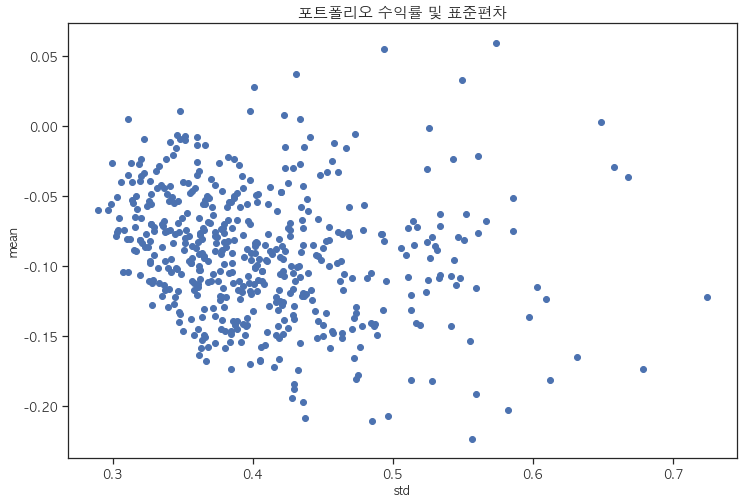

In [47]:
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('포트폴리오 수익률 및 표준편차', fontsize = 15)

In [48]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 이 부분을 군집별 포트폴리오마다 수정해줘야 합니다.
  mus = list(np.arange(-0.2,0.1,0.01))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list

In [49]:
weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_0)')

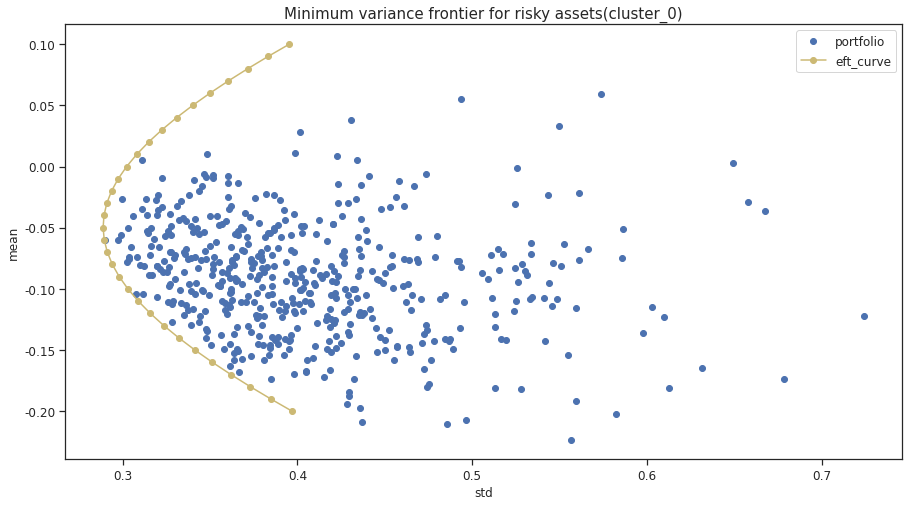

In [50]:
# Plot minimum variance frontier (최소 분산 곡선 그래프)
# Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

# Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_0)',fontsize=15)

#### -   2. cluster_1의 포트폴리오 구성

In [51]:
cluster_1.drop('cluster', axis = 1, inplace = True)

In [52]:
returns_matrix = cluster_1.values.T

In [53]:
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)  

In [54]:
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,Dollar_W,USA_TREASURY_W,Nikkei_W
0,0.259516,0.509059,0.116675,0.298872,0.007729,0.133061,0.313620,0.130042
1,0.302063,0.415563,0.051330,0.159071,0.246211,0.271982,0.176692,0.094713
2,0.226735,0.450614,0.204295,0.148466,0.069416,0.260143,0.204528,0.113153
3,0.337681,0.514848,0.152287,0.253339,0.090305,0.074299,0.270678,0.159092
4,0.387283,0.399408,0.068613,0.132653,0.202407,0.297477,0.087344,0.211505
...,...,...,...,...,...,...,...,...
495,0.615380,0.523428,0.126354,0.180263,0.265358,0.054837,0.053028,0.320160
496,0.543702,0.483529,0.044652,0.230049,0.290162,0.104335,0.104220,0.226582
497,0.317055,0.392539,0.120426,0.090349,0.239102,0.284942,0.128150,0.137030
498,0.268607,0.560326,0.266489,0.093159,0.045468,0.154224,0.225923,0.214738


In [55]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

Text(0.5, 1.0, '포트폴리오 수익률 및 표준편차')

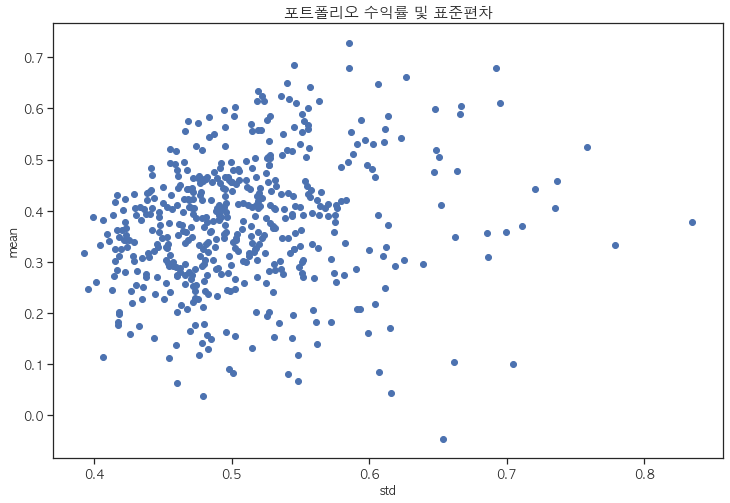

In [57]:
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('포트폴리오 수익률 및 표준편차', fontsize = 15)

In [58]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 계속 수정
  mus = list(np.arange(0,0.7,0.01))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list

In [59]:
weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_1)')

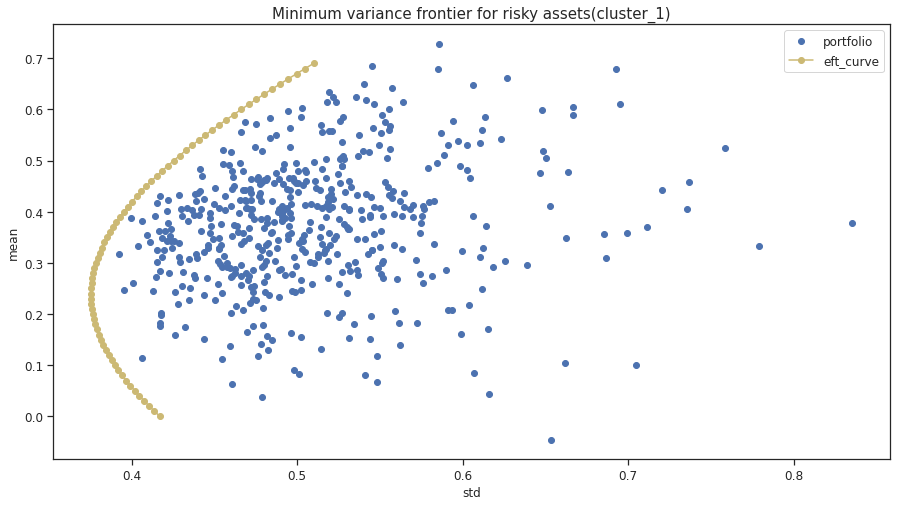

In [60]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_1)',fontsize=15)

#### -  3. cluster_2 의 포트폴리오 작성

In [61]:
cluster_2.drop('cluster', axis = 1, inplace = True)

In [62]:
returns_matrix = cluster_2.values.T

In [63]:
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)  

In [64]:
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,Dollar_W,USA_TREASURY_W,Nikkei_W
0,-1.246191,1.116474,0.409397,0.048050,0.111976,0.048959,0.344717,0.036901
1,-1.121124,0.901103,0.213678,0.031473,0.216647,0.088690,0.246598,0.202913
2,-0.802799,0.685664,0.191185,0.086926,0.246605,0.256975,0.088941,0.129367
3,-1.170440,0.799386,0.053545,0.191680,0.200792,0.165242,0.194095,0.194645
4,-1.005676,0.804111,0.220080,0.087336,0.152693,0.154908,0.203375,0.181608
...,...,...,...,...,...,...,...,...
495,-0.762135,0.853153,0.102139,0.095918,0.202611,0.155183,0.039969,0.404179
496,-1.242146,0.928482,0.107220,0.070808,0.284894,0.039439,0.228572,0.269066
497,-0.747553,0.689309,0.106761,0.034154,0.104178,0.317946,0.182299,0.254662
498,-0.671921,0.644718,0.085755,0.182466,0.152537,0.366130,0.036457,0.176654


In [65]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

Text(0.5, 1.0, '포트폴리오 수익률 및 표준편차')

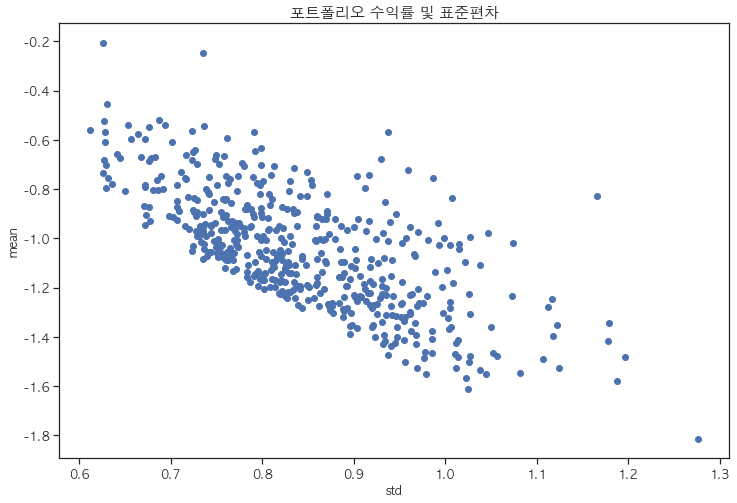

In [67]:
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('포트폴리오 수익률 및 표준편차', fontsize = 15)

In [68]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 계속 수정
  mus = list(np.arange(-2,-0.4,0.01))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list

In [69]:
weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_2)')

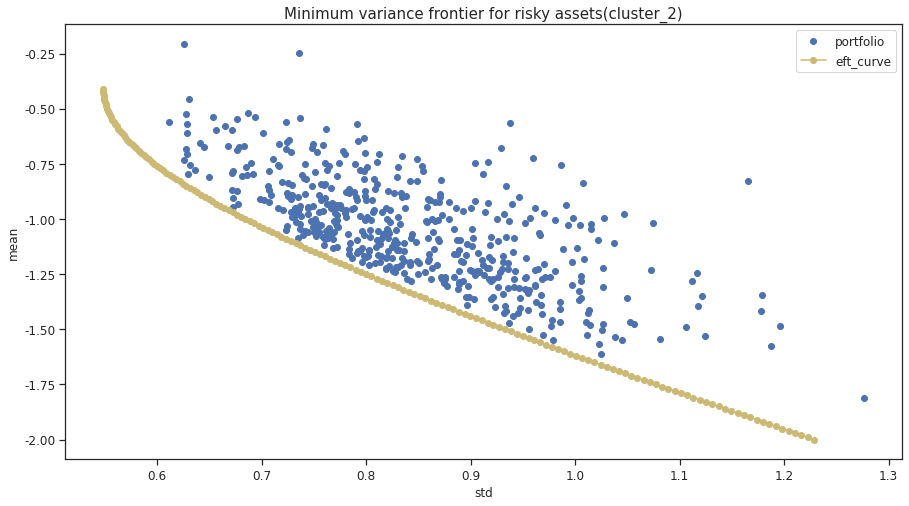

In [70]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_2)',fontsize=15)

#### -  4. cluster_3 의 포트폴리오 작성

In [71]:
cluster_3.drop('cluster', axis = 1, inplace = True)

In [72]:
returns_matrix = cluster_3.values.T

In [73]:
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)  

In [74]:
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,Dollar_W,USA_TREASURY_W,Nikkei_W
0,1.118548,1.095483,0.032906,0.526530,0.070911,0.068090,0.137784,0.163779
1,1.043012,0.801342,0.187480,0.148962,0.062959,0.245498,0.203268,0.151833
2,1.654623,1.209544,0.001213,0.098161,0.286796,0.043042,0.339097,0.231691
3,1.181702,0.862665,0.088941,0.099139,0.085913,0.281374,0.253167,0.191466
4,1.462561,1.139709,0.177163,0.057887,0.214931,0.001720,0.294328,0.253971
...,...,...,...,...,...,...,...,...
495,1.226934,0.958921,0.081109,0.083174,0.155795,0.127826,0.241107,0.310989
496,0.571290,0.952596,0.283190,0.103796,0.224908,0.062404,0.028029,0.297673
497,1.775303,1.274103,0.190342,0.247818,0.009759,0.040116,0.386630,0.125336
498,0.474405,0.870294,0.364119,0.346398,0.022348,0.195443,0.001982,0.069710


In [75]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

Text(0.5, 1.0, '포트폴리오 수익률 및 표준편차')

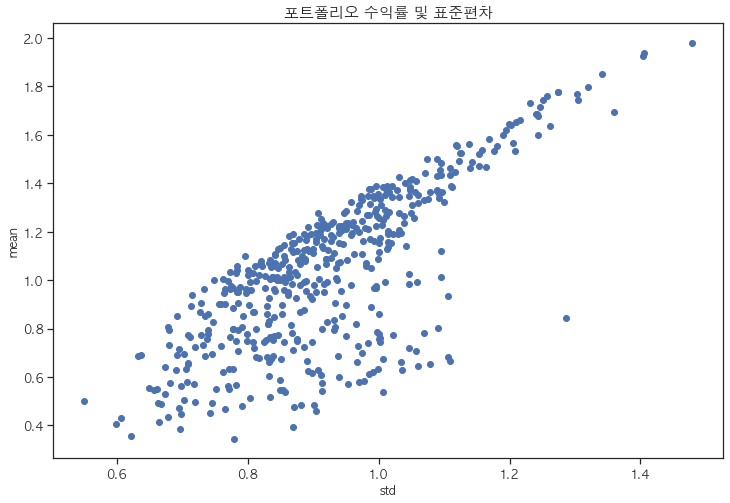

In [77]:
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('포트폴리오 수익률 및 표준편차', fontsize = 15)

In [78]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트)
  mus = list(np.arange(0.25,2,0.01))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list

In [79]:
weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_3)')

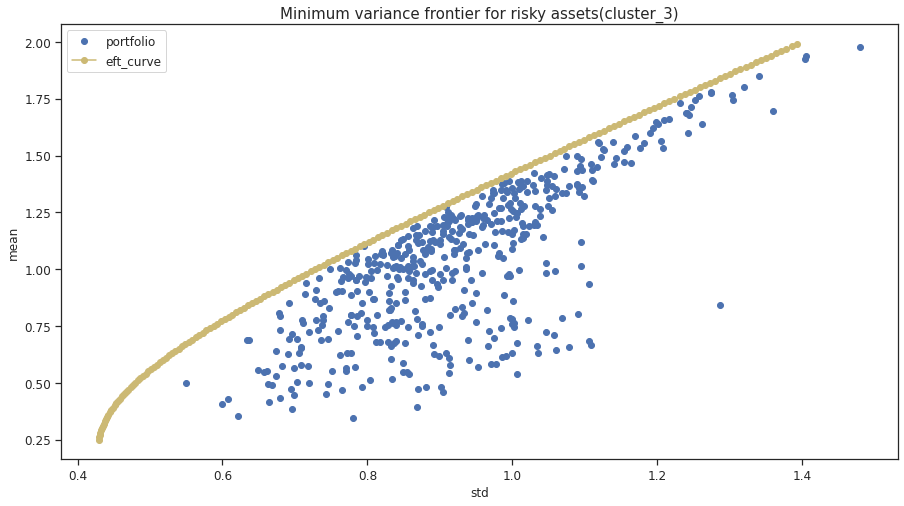

In [80]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_3)',fontsize=15)

# 결론 

- 수익률 : 군집3 > 군집1 > 군집2 > 군집0 

- 표준편차(위험) : 군집3 > 군집2 > 군집1 > 군집0  

- 군집3의 경우 HighRisk-HighReturn 군집, 군집0의 경우 LowRisk-LowReturn 입니다.  

- 계량적인 관점에서 볼때 군집2의 포트폴리오는 좋지않은 포트폴리오입니다. \
  왜냐하면 수익률은 군집1 > 군집2 이지만 Risk는 군집2 > 군집1이기 때문입니다.  

- 단순한 금융자산 투자보다는 합리적인 투자를 수행가능합니다.  

- 투자자가 원하는 수익률과 위험을 설정 및 군집을 설정해서 투자하면 더욱 이상적인 투자가능합니다.

## 감사합니다!!

## 외부데이터 링크 

https://drive.google.com/file/d/1g6hNFCZisO9vUmhTuGmli9wdG2NXZ1CH/view?usp=sharing